<a href="https://colab.research.google.com/github/qwiksilva/cs224w-github-rec/blob/master/Github_Rec_FullData_GraphBuilder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
%reload_ext google.colab.data_table

In [0]:
# Fetch the largest 20 projects by the number of prs they have.
%%bigquery --project cs224w-257119 df
SELECT prs.num_prs, prs.base_repo_id, projects.name, projects.deleted
FROM (
  SELECT COUNT(base_repo_id) as num_prs, base_repo_id
  FROM `ghtorrent-bq.ght_2018_04_01.pull_requests`
  GROUP BY base_repo_id
) prs
INNER JOIN `ghtorrent-bq.ght_2018_04_01.projects` projects ON prs.base_repo_id = projects.id
ORDER BY prs.num_prs DESC
LIMIT 20


In [0]:
df

,num_prs,base_repo_id,name,deleted
0,82846,20170979,everypolitician-data,False
1,69340,70604300,signcla-probe-repo,False
2,55760,789,liferay-portal,False
3,54805,33253535,sauron,False
4,40082,9570147,homebrew-cask,False
5,33504,6866209,homebrew,False
6,31212,202,gaia,False
7,30909,1803391,snoopys-sandbox,False
8,28820,3777,nixpkgs,False
9,28289,22091370,kubernetes,False


In [0]:
# Fetch the largest 20 projects by number of unqiue commenters
%%bigquery --project cs224w-257119 df
SELECT COUNT(comments.comment_id) as num_comments, COUNT(DISTINCT comments.user_id) as num_commenters, prs.base_repo_id
FROM `ghtorrent-bq.ght_2018_04_01.pull_request_comments` comments
INNER JOIN `ghtorrent-bq.ght_2018_04_01.pull_requests` prs ON prs.id = comments.pull_request_id
GROUP BY prs.base_repo_id
ORDER BY num_commenters DESC
LIMIT 20

In [0]:
%%bigquery --project cs224w-257119 pr_comments_spark
SELECT pr_comments.pull_request_id AS pr_id, 
pr.pullreq_id as github_pr_id,
pr_comments.user_id as commenter_id,
users1.login as commenter_username,
IFNULL(followers_stat.fl_count, 0) as commenter_follower_count,
IFNULL(commits_stat1.cm_count, 0) as commenter_total_github_commit_count, # As author
IFNULL(commits_stat2.cm_count, 0) as commenter_base_repo_commit_count, # As author
head_commits.author_id as head_commit_author_id,
users2.login as head_commit_author_username,
head_commits.committer_id as head_commit_committer_id,
users6.login as head_commit_committer_username,
base_commits.author_id as base_commit_author_id,
users3.login as base_commit_author_username,
base_commits.committer_id as base_commit_committer_id,
users7.login as base_commit_committer_username,
pr.head_repo_id,
pr.base_repo_id,
base_project.owner_id as base_repo_owner,
users4.login as base_repo_owner_username,
head_project.owner_id as head_repo_owner_id,
users5.login as head_repo_owner_username,
pr.head_commit_id,
pr.base_commit_id,
pr.pullreq_id,
pr_comments.created_at as comment_created_at,
pr_comments.position as comment_position,
pr_comments.comment_id,
pr_comments.body as comment_body
FROM 
`ghtorrent-bq.ght_2018_04_01.pull_request_comments` pr_comments
INNER JOIN `ghtorrent-bq.ght_2018_04_01.pull_requests` pr
ON pr_comments.pull_request_id = pr.id
INNER JOIN `ghtorrent-bq.ght_2018_04_01.commits` head_commits
ON pr.head_commit_id = head_commits.id
INNER JOIN `ghtorrent-bq.ght_2018_04_01.commits` base_commits
ON pr.base_commit_id = base_commits.id
INNER JOIN `ghtorrent-bq.ght_2018_04_01.projects` base_project
ON base_project.id = pr.base_repo_id
INNER JOIN `ghtorrent-bq.ght_2018_04_01.projects` head_project
ON head_project.id = pr.head_repo_id
LEFT JOIN ( # Map with followers to count num-followers
    SELECT followers.follower_id, COUNT(DISTINCT followers.user_id) as fl_count
    FROM `ghtorrent-bq.ght_2018_04_01.followers` followers
    GROUP BY followers.follower_id
) followers_stat
ON pr_comments.user_id = followers_stat.follower_id
LEFT JOIN (  # Count num-contributions in entire Github
    SELECT commits1.author_id, COUNT(*) as cm_count
    FROM `ghtorrent-bq.ght_2018_04_01.commits` commits1
    GROUP BY commits1.author_id
) commits_stat1
ON pr_comments.user_id = commits_stat1.author_id
LEFT JOIN (  # Count num-contributions so far in the base repo
    SELECT commits2.author_id, commits2.project_id, COUNT(*) as cm_count
    FROM `ghtorrent-bq.ght_2018_04_01.commits` commits2
    GROUP BY commits2.author_id, commits2.project_id
) commits_stat2
ON pr_comments.user_id = commits_stat2.author_id AND pr.base_repo_id= commits_stat2.project_id
INNER JOIN `ghtorrent-bq.ght_2018_04_01.users` users1 # Map all useful userid to username for sanity checking
ON pr_comments.user_id = users1.id
INNER JOIN `ghtorrent-bq.ght_2018_04_01.users` users2
ON head_commits.author_id = users2.id
INNER JOIN `ghtorrent-bq.ght_2018_04_01.users` users6
ON head_commits.committer_id = users6.id
INNER JOIN `ghtorrent-bq.ght_2018_04_01.users` users3
ON base_commits.author_id = users3.id
INNER JOIN `ghtorrent-bq.ght_2018_04_01.users` users7
ON base_commits.committer_id = users7.id
INNER JOIN `ghtorrent-bq.ght_2018_04_01.users` users4
ON base_project.owner_id = users4.id
INNER JOIN `ghtorrent-bq.ght_2018_04_01.users` users5
ON head_project.owner_id = users5.id
#Spark
WHERE pr.base_repo_id = 8196280

# Sanity Check

The head committer and author tends to be the same. The base committer and author can vary. I checked, and the head commit ids match the user who submitted the pull request. I'm still not sure how exactly to interpertet the base_commit_author and base_committer_ids. For rereference, this is the pull request corresponding to row 0 (github_pr_id 18476)

https://github.com/apache/spark/pull/18476

The usernames of the ids are as follows:
- head_commit_author_id / head_commit_committer_id: **sadikovi**
- base_commit_author_id: **liufengdb**
- base_commit_committer_id: **zsxwing**


In [53]:
pr_comments_spark.loc[pr_comments_spark.pullreq_id == 18476, :]

,pr_id,github_pr_id,commenter_id,commenter_username,commenter_follower_count,commenter_total_github_commit_count,commenter_base_repo_commit_count,head_commit_author_id,head_commit_author_username,head_commit_committer_id,head_commit_committer_username,base_commit_author_id,base_commit_author_username,base_commit_committer_id,base_commit_committer_username,head_repo_id,base_repo_id,base_repo_owner,base_repo_owner_username,head_repo_owner_id,head_repo_owner_username,head_commit_id,base_commit_id,pullreq_id,comment_created_at,comment_position,comment_id,comment_body
108881,26035738,18476,6682,JoshRosen,401,6140,1782,4388120,sadikovi,4388120,sadikovi,10067869,liufengdb,478320,zsxwing,38647905,8196280,13369,apache,4388120,sadikovi,726517541,726415645,18476,2017-07-01 00:19:33+00:00,31,125149417,If you're only documenting this in master then...
108882,26035738,18476,2062189,tgravescs,24,584,71,4388120,sadikovi,4388120,sadikovi,10067869,liufengdb,478320,zsxwing,38647905,8196280,13369,apache,4388120,sadikovi,726517541,726415645,18476,2017-06-30 13:28:37+00:00,35,125038588,we may want to add a comment about increasing ...
108883,26035738,18476,2062189,tgravescs,24,584,71,4388120,sadikovi,4388120,sadikovi,10067869,liufengdb,478320,zsxwing,38647905,8196280,13369,apache,4388120,sadikovi,726517541,726415645,18476,2017-06-30 22:05:07+00:00,35,125138509,"yep, looks good."
108884,26035738,18476,2062189,tgravescs,24,584,71,4388120,sadikovi,4388120,sadikovi,10067869,liufengdb,478320,zsxwing,38647905,8196280,13369,apache,4388120,sadikovi,726517541,726415645,18476,2017-06-30 22:05:48+00:00,35,125138598,"ah sorry, my fault we should change ""value wil..."
108885,26035738,18476,2062189,tgravescs,24,584,71,4388120,sadikovi,4388120,sadikovi,10067869,liufengdb,478320,zsxwing,38647905,8196280,13369,apache,4388120,sadikovi,726517541,726415645,18476,2017-06-30 21:53:54+00:00,35,125137046,"thanks for updating, sorry a couple minor nits..."
108886,26035738,18476,4388120,sadikovi,20,2718,2,4388120,sadikovi,4388120,sadikovi,10067869,liufengdb,478320,zsxwing,38647905,8196280,13369,apache,4388120,sadikovi,726517541,726415645,18476,2017-06-30 21:25:40+00:00,35,125133239,@tgravescs I updated comment to include note a...
108887,26035738,18476,4388120,sadikovi,20,2718,2,4388120,sadikovi,4388120,sadikovi,10067869,liufengdb,478320,zsxwing,38647905,8196280,13369,apache,4388120,sadikovi,726517541,726415645,18476,2017-06-30 21:59:05+00:00,35,125137670,"Will do, thanks. I am going to update descript..."
108888,26035738,18476,4388120,sadikovi,20,2718,2,4388120,sadikovi,4388120,sadikovi,10067869,liufengdb,478320,zsxwing,38647905,8196280,13369,apache,4388120,sadikovi,726517541,726415645,18476,2017-06-30 22:07:26+00:00,35,125138807,"Sure, will update accordingly. Thanks!"


In [35]:
pr_comments_spark.loc[pr_comments_spark.pullreq_id == 18476, ["commenter_username", "comment_created_at", "comment_body"]].values

array([['sadikovi', Timestamp('2017-06-30 21:59:05+0000', tz='UTC'),
        'Will do, thanks. I am going to update description to this:  ```  Capacity for event queue in Spark listener bus, must be greater than 0.   Consider increasing value (e.g. 20000) if listener events are dropped.   Increasing this value will result in the dr'],
       ['sadikovi', Timestamp('2017-06-30 22:07:26+0000', tz='UTC'),
        'Sure, will update accordingly. Thanks!'],
       ['sadikovi', Timestamp('2017-06-30 21:25:40+0000', tz='UTC'),
        '@tgravescs I updated comment to include note about memory increase. Could you review again, please? Thanks.'],
       ['JoshRosen', Timestamp('2017-07-01 00:19:33+0000', tz='UTC'),
        "If you're only documenting this in master then please use `spark.scheduler.listenerbus.eventqueue.capacity` instead (see definition in code and git blame for explanation)."],
       ['tgravescs', Timestamp('2017-06-30 22:05:48+0000', tz='UTC'),
        'ah sorry, my fault we

In [0]:
#Download to csv
from google.colab import files
path = './pr_comments_spark_with_commenter_stat_11012019.csv'
with open(path, 'w') as f:
  pr_comments_spark.to_csv(f)
files.download(path)

# EDA

In [56]:
pr_comments_spark.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130634 entries, 0 to 130633
Data columns (total 28 columns):
pr_id                                  130634 non-null int64
github_pr_id                           130634 non-null int64
commenter_id                           130634 non-null int64
commenter_username                     130634 non-null object
commenter_follower_count               130634 non-null int64
commenter_total_github_commit_count    130634 non-null int64
commenter_base_repo_commit_count       130634 non-null int64
head_commit_author_id                  130634 non-null int64
head_commit_author_username            130634 non-null object
head_commit_committer_id               130634 non-null int64
head_commit_committer_username         130634 non-null object
base_commit_author_id                  130634 non-null int64
base_commit_author_username            130634 non-null object
base_commit_committer_id               130634 non-null int64
base_commit_committer_username 

In [0]:
selected = ['pr_id', 'github_pr_id', 'commenter_id', 'commenter_username',
            'commenter_follower_count', 'commenter_total_github_commit_count', 'commenter_base_repo_commit_count',
            'comment_created_at', 'comment_body',
            'head_commit_author_id', 'head_commit_author_username', 'head_commit_committer_id', 'head_commit_committer_username'] # author == committer
core_df = pr_comments_spark.loc[:, selected]

In [262]:
core_df[core_df.github_pr_id == 15965].sort_values('comment_created_at')[:10]

,pr_id,github_pr_id,commenter_id,commenter_username,commenter_follower_count,commenter_total_github_commit_count,commenter_base_repo_commit_count,comment_created_at,comment_body,head_commit_author_id,head_commit_author_username,head_commit_committer_id,head_commit_committer_username
99286,19033783,15965,231317,srowen,1085,7913,753,2016-11-21 14:31:38+00:00,Your change is reverting some other changes li...,7860135,ZakariaHili,30351173,web-flow
99298,19033783,15965,7860135,ZakariaHili,0,81,2,2016-11-21 15:05:29+00:00,"Hi Sean, I will change the file, then i will ...",7860135,ZakariaHili,30351173,web-flow
99299,19033783,15965,6163299,hhbyyh,55,1302,422,2016-11-21 17:50:58+00:00,"remove the extra space, please use [Spark root...",7860135,ZakariaHili,30351173,web-flow
99300,19033783,15965,6163299,hhbyyh,55,1302,422,2016-11-21 17:53:58+00:00,"The comment may not be necessary, as it's used...",7860135,ZakariaHili,30351173,web-flow
99292,19033783,15965,7860135,ZakariaHili,0,81,2,2016-11-21 19:37:13+00:00,"I cleaned the code, then I run /dev/lint-scala...",7860135,ZakariaHili,30351173,web-flow
99293,19033783,15965,7860135,ZakariaHili,0,81,2,2016-11-21 19:38:15+00:00,"sorry for my late, I was busy, now , I think ...",7860135,ZakariaHili,30351173,web-flow
99289,19033783,15965,231317,srowen,1085,7913,753,2016-11-22 09:59:43+00:00,This still has several problems. This can't be...,7860135,ZakariaHili,30351173,web-flow
99287,19033783,15965,231317,srowen,1085,7913,753,2016-11-22 09:59:53+00:00,fix spacing here,7860135,ZakariaHili,30351173,web-flow
99290,19033783,15965,7860135,ZakariaHili,0,81,2,2016-11-22 10:03:47+00:00,Ok it's removed,7860135,ZakariaHili,30351173,web-flow
99297,19033783,15965,7860135,ZakariaHili,0,81,2,2016-11-22 10:04:04+00:00,the space is fixed,7860135,ZakariaHili,30351173,web-flow


In [261]:
core_df[core_df.github_pr_id == 8880].sort_values('comment_created_at')[:10]

,pr_id,github_pr_id,commenter_id,commenter_username,commenter_follower_count,commenter_total_github_commit_count,commenter_base_repo_commit_count,comment_created_at,comment_body,head_commit_author_id,head_commit_author_username,head_commit_committer_id,head_commit_committer_username
104183,9475390,8880,115196,vanzin,44,3483,902,2015-09-28 17:41:42+00:00,no need to import `Byte`,6186517,kellyzly,707004,winningsix
104341,9475390,8880,115196,vanzin,44,3483,902,2015-09-28 17:42:10+00:00,"All these classes should be `private[spark]`, ...",6186517,kellyzly,707004,winningsix
104145,9475390,8880,115196,vanzin,44,3483,902,2015-09-28 17:42:49+00:00,nit: don't use capital letters only for parame...,6186517,kellyzly,707004,winningsix
104184,9475390,8880,115196,vanzin,44,3483,902,2015-09-28 17:43:31+00:00,Can you add a scaladoc describing what this me...,6186517,kellyzly,707004,winningsix
104214,9475390,8880,115196,vanzin,44,3483,902,2015-09-28 17:45:09+00:00,You could use Guava's `Objects.toStringHelper()`.,6186517,kellyzly,707004,winningsix
104182,9475390,8880,115196,vanzin,44,3483,902,2015-09-28 17:45:55+00:00,nit: no need to specify the variable's type in...,6186517,kellyzly,707004,winningsix
104239,9475390,8880,115196,vanzin,44,3483,902,2015-09-28 17:46:13+00:00,nit: `.foreach { part =>`,6186517,kellyzly,707004,winningsix
104212,9475390,8880,115196,vanzin,44,3483,902,2015-09-28 17:48:05+00:00,"This whole method can be written as: ""....",6186517,kellyzly,707004,winningsix
104189,9475390,8880,115196,vanzin,44,3483,902,2015-09-28 17:51:21+00:00,use `name match { ... }` instead of cascading ...,6186517,kellyzly,707004,winningsix
104264,9475390,8880,115196,vanzin,44,3483,902,2015-09-28 17:53:04+00:00,nit: import order. This line should come befor...,6186517,kellyzly,707004,winningsix


In [61]:
len(core_df[core_df.head_commit_author_id != core_df.head_commit_committer_id]) # Number of conflicts between author/commiter in head-repo

917

# Iterate Nodes

In [0]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [230]:
def extract_node_ids(pr_id, data):
    # Extract PR owner and metadata
    pr_df = data.loc[data.pr_id == pr_id, :]
    commenter_set = set(pr_df.commenter_id.values)
    head_commiter_set = set(pr_df.head_commit_committer_id.values)
    head_author_set = set(pr_df.head_commit_author_id.values)
     # Only counted as a PR owner if participating in the comments
    pr_owner_set = (head_author_set | head_commiter_set) & commenter_set
    reviewer_set = commenter_set - pr_owner_set
    return pr_owner_set, reviewer_set

def extract_metadata(target, pr_id, data):
    metadata_cols = ['commenter_username', 'commenter_follower_count',
                     'commenter_total_github_commit_count', 'commenter_base_repo_commit_count']
    metadata_dict = data.loc[(data.commenter_id == target) & (data.pr_id == pr_id), metadata_cols].iloc[0].to_dict()
    return metadata_dict

print(extract_node_ids(9475390, core_df)) # PR 8880
print(extract_metadata(707004, 9475390, core_df)) # Owner of PR 8880

({707004}, {478320, 115196})
{'commenter_username': 'winningsix', 'commenter_follower_count': 25, 'commenter_total_github_commit_count': 543, 'commenter_base_repo_commit_count': 12}


In [0]:
def build_gh_rec_graph(data):
    pr_id_list = data.pr_id.value_counts().index.values
    graph = nx.Graph()
    for pr_id in tqdm_notebook(pr_id_list):
        pr_owner_set, reviewer_set = extract_node_ids(pr_id, data)
        # Add Owner node
        for pr_owner_id in pr_owner_set:
            pr_owner_metadata = extract_metadata(pr_owner_id, pr_id, data)
            graph.add_node(pr_owner_id, color=Spectral4[-1], **pr_owner_metadata) # Add metadata for PR owner, color: red
        # Add Reviewer node
        for reviewer_id in reviewer_set:
            reviewer_metadata = extract_metadata(reviewer_id, pr_id, data)
            graph.add_node(reviewer_id, color=Spectral4[0], **reviewer_metadata) # Add metadata for each Reviewer, color: red
            graph.add_edge(pr_owner_id, reviewer_id) # TODO: add info to edges
    return graph

def sanity_check(graph, data):
    num_commenters = len(set(data.commenter_id.values))
    # Add check for edges here (multiple comments across PRs)
    assert graph.number_of_nodes == num_commenters

In [232]:
basic_gh_graph = build_gh_rec_graph(core_df)

In [233]:
print(nx.info(basic_gh_graph))

Name: 
Type: Graph
Number of nodes: 1247
Number of edges: 6452
Average degree:  10.3480


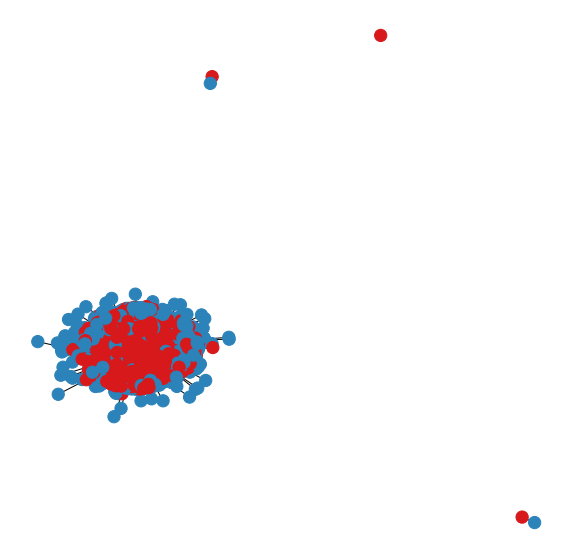

In [242]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
options = {
    'node_size': 150,
    'node_color': list(nx.get_node_attributes(basic_gh_graph, 'color').values()),
    'labels': nx.get_node_attributes(graph, 'commenter_username'),
    'alpha': 1,
    'fontweight': 'bold',
}
nx.draw(basic_gh_graph, ax=ax, with_labels=False, **options)

# Bokeh Plot

WIP

In [256]:
from bokeh.io import show, output_file, output_notebook
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, BoxZoomTool, ResetTool, WheelZoomTool, SaveTool, UndoTool
from bokeh.models.graphs import from_networkx
from bokeh.palettes import Spectral4
from bokeh.layouts import row, column

output_notebook()

plot = Plot(plot_width=400, plot_height=400, x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.title.text = "Graph Interaction Demonstration"
node_hover_tool = HoverTool(tooltips=[("commenter_username", "@commenter_username"),
                                      ("follower-count", "@commenter_username"),
                                      ("gh-commit-count", "@commenter_total_github_commit_count"),
                                      ("base-commit-count", "@commenter_base_repo_commit_count")]) # Should be loop
plot.add_tools(SaveTool(), BoxZoomTool(), ResetTool(), WheelZoomTool(), UndoTool())
graph_renderer = from_networkx(basic_gh_graph, nx.spring_layout, scale=1, center=(0, 0))
graph_renderer.node_renderer.glyph = Circle(size=15, fill_color="color")
graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=1)
plot.renderers.append(graph_render)

show(plot) # Follow https://docs.bokeh.org/en/latest/docs/user_guide/graph.html line by line wtf

TypeError: ignored